In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import gc
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/layeraiairqualitypredictionchallenge/SampleSubmission.csv
/kaggle/input/layeraiairqualitypredictionchallenge/train.csv
/kaggle/input/layeraiairqualitypredictionchallenge/test.csv


In [2]:
# !pip install layer
# import layer
# from layer.decorators import dataset,model, pip_requirements

In [4]:
train = pd.read_csv('../input/layeraiairqualitypredictionchallenge/train.csv')
test = pd.read_csv("../input/layeraiairqualitypredictionchallenge/test.csv")

In [5]:
ntrain= train.shape[0]
ntest = test.shape[0]
train_set = pd.concat((train, test)).reset_index(drop=True)

In [6]:
train_set.shape

(14177, 71)

In [7]:
train_set.head

<bound method NDFrame.head of                   ID        date    device  site_latitude  site_longitude  \
0      ID_JBYXJEUZ8X  2020-03-18  ANQ16PZJ       0.353465       32.560322   
1      ID_PEJJNLBUPR  2019-10-13  AB6051M4       0.390741       32.582257   
2      ID_21L8UZQO1T  2019-12-21  A0WN66FH       0.285751       32.578325   
3      ID_GNW2G8J4T8  2020-02-20     aq_41      -1.244985       29.989236   
4      ID_4XOX2V6SK0  2019-04-17     aq_41      -1.244985       29.989236   
...              ...         ...       ...            ...             ...   
14172  ID_NYKGOYFBKZ  2020-08-25     aq_76       0.357987       32.584100   
14173  ID_IWO4EVLHSQ  2020-08-21  AB6051M4       0.390741       32.582257   
14174  ID_G1M1IMY9WU  2020-11-07  AB6051M4       0.390741       32.582257   
14175  ID_DXV65Q1QXI  2020-09-10     aq_61       0.373078       32.628226   
14176  ID_RY4ONQKO9E  2020-10-03     aq_30       0.059604       32.460320   

       humidity  temp_mean  SulphurDioxide_SO

In [8]:
#Number of devices
train_set["device"].unique()

array(['ANQ16PZJ', 'AB6051M4', 'A0WN66FH', 'aq_41', 'aq_54', 'AY2J2Q7Z',
       'AR2RHV97', 'aq_64', 'A95X5F9T', 'AW66FF7V', 'APZ80RTM', 'aq_31',
       'aq_59', 'aq_30', 'aq_76', 'aq_29', 'aq_70', 'APYZC5J7', 'aq_56',
       'AJCK5L86', 'aq_46', 'aq_61', 'aq_49', 'AKSLS0FP', 'aq_74',
       'aq_35', 'aq_43', 'aq_52', 'aq_60', 'aq_36', 'aq_45', 'aq_57',
       'aq_47', 'aq_79', 'aq_91', 'aq_98'], dtype=object)

In [9]:
#countsof occurrences of each device
unique, counts = np.unique(train_set["device"], return_counts=True)
dict(zip(unique, counts))

{'A0WN66FH': 462,
 'A95X5F9T': 462,
 'AB6051M4': 462,
 'AJCK5L86': 462,
 'AKSLS0FP': 462,
 'ANQ16PZJ': 462,
 'APYZC5J7': 462,
 'APZ80RTM': 462,
 'AR2RHV97': 462,
 'AW66FF7V': 462,
 'AY2J2Q7Z': 462,
 'aq_29': 447,
 'aq_30': 598,
 'aq_31': 314,
 'aq_35': 348,
 'aq_36': 404,
 'aq_41': 586,
 'aq_43': 491,
 'aq_45': 500,
 'aq_46': 486,
 'aq_47': 332,
 'aq_49': 485,
 'aq_52': 399,
 'aq_54': 417,
 'aq_56': 324,
 'aq_57': 294,
 'aq_59': 395,
 'aq_60': 295,
 'aq_61': 400,
 'aq_64': 237,
 'aq_70': 372,
 'aq_74': 336,
 'aq_76': 245,
 'aq_79': 307,
 'aq_91': 80,
 'aq_98': 3}

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14177 entries, 0 to 14176
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID                                                        14177 non-null  object 
 1   date                                                      14177 non-null  object 
 2   device                                                    14177 non-null  object 
 3   site_latitude                                             14177 non-null  float64
 4   site_longitude                                            14177 non-null  float64
 5   humidity                                                  14177 non-null  float64
 6   temp_mean                                                 14157 non-null  float64
 7   SulphurDioxide_SO2_column_number_density                  5205 non-null   float64
 8   SulphurDioxide_S

In [11]:
percent_missing = train_set.isnull().sum() * 100 / len(train_set)
missing_values_train = pd.DataFrame({'column_name': train_set.columns,
                                 'percent_missing': percent_missing})
missing_values_train

,column_name,percent_missing
ID,ID,0.000000
date,date,0.000000
device,device,0.000000
site_latitude,site_latitude,0.000000
site_longitude,site_longitude,0.000000
...,...,...
Cloud_sensor_azimuth_angle,Cloud_sensor_azimuth_angle,14.276645
Cloud_sensor_zenith_angle,Cloud_sensor_zenith_angle,14.276645
Cloud_solar_azimuth_angle,Cloud_solar_azimuth_angle,14.276645
Cloud_solar_zenith_angle,Cloud_solar_zenith_angle,14.276645


In [12]:
missing_values_train.loc[missing_values_train["percent_missing"] >0]

,column_name,percent_missing
temp_mean,temp_mean,0.141074
SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density,63.285603
SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_column_number_density_amf,63.285603
SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_SO2_slant_column_number_density,63.285603
SulphurDioxide_cloud_fraction,SulphurDioxide_cloud_fraction,63.285603
...,...,...
Cloud_sensor_azimuth_angle,Cloud_sensor_azimuth_angle,14.276645
Cloud_sensor_zenith_angle,Cloud_sensor_zenith_angle,14.276645
Cloud_solar_azimuth_angle,Cloud_solar_azimuth_angle,14.276645
Cloud_solar_zenith_angle,Cloud_solar_zenith_angle,14.276645


Visualizations

In [13]:
train_set.sort_values(by=['date'], ascending = True)

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
2961,ID_CE4DAC712J,2019-03-14,aq_30,0.059604,32.460320,0.846583,22.641667,-0.000251,0.527936,-0.000133,...,9897.856413,30049.924328,8889.992462,5.467293,0.206835,-98.336071,52.513670,-95.490160,28.237128,31.415000
1577,ID_HIQKM4CT8J,2019-03-15,aq_30,0.059604,32.460320,0.783833,24.325000,-0.000132,0.562716,-0.000074,...,1156.244263,88145.250000,1156.244263,5.077599,0.241493,-100.671776,26.637129,-95.566147,23.584166,28.940000
8996,ID_RBKKDULJSK,2019-03-16,aq_30,0.059604,32.460320,0.741972,25.725000,-0.000169,0.550671,-0.000093,...,1156.241545,88152.936593,1156.241545,5.075785,0.221404,76.479022,11.730469,-95.646289,18.962576,34.349272
2076,ID_AAI6SF03WX,2019-03-17,aq_30,0.059604,32.460320,0.748049,24.607986,-0.000286,0.669683,-0.000192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.131879
2831,ID_TBMFQGXQ5D,2019-03-18,aq_30,0.059604,32.460320,0.735576,24.857639,-0.000120,0.656247,-0.000079,...,1157.109051,88179.422887,1157.109051,4.536230,0.154478,71.651095,62.237459,-96.222612,9.773934,30.584458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127,ID_EXI7LNT84X,2020-12-31,aq_54,0.356400,32.573000,0.864569,20.422222,NaN,NaN,NaN,...,7567.250672,46406.195262,6567.250672,8.268939,0.233096,76.575499,10.536709,-141.164739,30.633657,NaN
11689,ID_6IIMDQC260,2020-12-31,aq_91,0.332609,32.610047,0.864576,20.440278,NaN,NaN,NaN,...,6852.777344,50035.757812,5852.777344,6.519915,0.219235,76.600716,10.252380,-141.068222,30.626919,NaN
10159,ID_6W9D99LCCY,2020-12-31,aq_43,0.289040,32.589580,0.858764,21.663043,NaN,NaN,NaN,...,6653.659233,51924.122121,5653.659233,9.358231,0.217126,76.566090,10.676411,-141.076199,30.563439,NaN
13602,ID_IJTBIDZ69I,2020-12-31,aq_46,0.298750,32.615000,0.855688,20.968403,NaN,NaN,NaN,...,7274.685708,48129.417910,6274.685708,7.153924,0.214478,76.584419,10.453038,-141.063796,30.592477,NaN


In [14]:
# def checkNull_fillData(df):
#     for col in df.columns:
#         if len(df.loc[df[col].isnull() == True]) != 0:
#             if df[col].dtype == "float64" or df[col].dtype == "int64":
#                 df.loc[df[col].isnull() == True,col] = df[col].median()
#             else:
#                 df.loc[df[col].isnull() == True,col] = df[col].mode()[0]

In [15]:
# train_set = train_set.groupby(["device"])
null_cols = [col for col in train_set.columns if train_set[col].isnull().any().sum() > 0]
for col in null_cols:
    train_set[col] = train_set.groupby('device')[col].transform(lambda x: x.bfill())

In [16]:
print(null_cols)

['temp_mean', 'SulphurDioxide_SO2_column_number_density', 'SulphurDioxide_SO2_column_number_density_amf', 'SulphurDioxide_SO2_slant_column_number_density', 'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'SulphurDioxide_solar_zenith_angle', 'SulphurDioxide_SO2_column_number_density_15km', 'CarbonMonoxide_CO_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_NO2_column_number_density', 'NitrogenDioxide_tropospheric_NO2_column_number_density', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'NitrogenDioxide_NO2_slant_column_number_density', 'NitrogenDioxide_tropopause_pressure', 'NitrogenDioxide_absorbing_aerosol_index', 'NitrogenDi

In [17]:
# train_set = train_set.ffill()

In [18]:
# train_set = train_set.drop(['site_latitude', 'site_longitude'], axis=1)

In [19]:
train_set["NitrogenDioxide_NO2_column_number_density"].fillna(0)

0        0.000076
1        0.000051
2        0.000043
3        0.000038
4        0.000032
           ...   
14172    0.000000
14173    0.000000
14174    0.000000
14175    0.000000
14176    0.000083
Name: NitrogenDioxide_NO2_column_number_density, Length: 14177, dtype: float64

In [20]:
percent_missing = train_set.isnull().sum() * 100 / len(train_set)
missing_values_train = pd.DataFrame({'column_name': train_set.columns,
                                 'percent_missing': percent_missing})
missing_values_train

,column_name,percent_missing
ID,ID,0.000000
date,date,0.000000
device,device,0.000000
site_latitude,site_latitude,0.000000
site_longitude,site_longitude,0.000000
...,...,...
Cloud_sensor_azimuth_angle,Cloud_sensor_azimuth_angle,0.035268
Cloud_sensor_zenith_angle,Cloud_sensor_zenith_angle,0.035268
Cloud_solar_azimuth_angle,Cloud_solar_azimuth_angle,0.035268
Cloud_solar_zenith_angle,Cloud_solar_zenith_angle,0.035268


In [21]:
devices = train_set["device"].unique()

In [22]:
train_set['date'] = pd.to_datetime(train_set['date'], errors='coerce')
train_set['year'] = train_set['date'].dt.to_period('Y')
train_set['month'] = train_set['date'].dt.to_period("M")
# list_YM = [i.split(" ")[0][:-3] for i in  list(train_set['date'])]
# train_set['YM'] = list_YM
# train_set['Year'] = list_Year
# train_set['Month'] = list_Month

In [23]:
train_set["YM"] = train_set["date"].dt.strftime('%Y-%m')

In [24]:
df_monthly = train_set.groupby(['device', 'YM', 'year', 'month']).mean()
columns = train_set.columns
unwanted = ['device', 'YM', 'year', 'month', "ID", "date"]
columns = [e for e in columns if e not in unwanted]
df_monthly = df_monthly[columns].reset_index()

In [25]:
df_monthly.sort_values(by=['YM'], ascending = True)

,device,YM,year,month,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
193,aq_30,2019-03,2019,2019-03,0.059604,32.460320,0.775098,24.519901,-0.000091,0.659185,...,6845.034226,52551.070747,6233.290148,5.466893,0.188371,-41.820107,38.769236,-84.716045,23.405615,32.141655
261,aq_41,2019-04,2019,2019-04,-1.244985,29.989236,0.901520,16.893852,0.000032,0.983816,...,5952.784588,56805.752730,5002.784589,16.640838,0.319140,-21.829840,43.224975,-56.228441,26.949903,62.050518
194,aq_30,2019-04,2019,2019-04,0.059604,32.460320,0.806717,23.591225,0.000040,0.714619,...,10019.577455,34948.933381,9019.577445,7.394584,0.193301,-47.061234,38.392162,-72.601338,28.492536,25.572641
262,aq_41,2019-05,2019,2019-05,-1.244985,29.989236,0.913940,17.069079,-0.000014,1.028418,...,5652.486501,59506.212336,4783.527822,13.084450,0.329226,-10.331781,38.804256,-45.297334,30.389641,59.638955
195,aq_30,2019-05,2019,2019-05,0.059604,32.460320,0.851955,22.455169,0.000028,0.780364,...,9829.491457,36879.575512,8830.272028,6.329283,0.199357,-38.011531,43.701377,-55.936539,30.416206,23.584156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,AY2J2Q7Z,2020-12,2020,2020-12,0.307584,32.567078,0.816924,22.906041,-0.000091,0.776950,...,6083.998444,57387.493486,5112.946698,11.450512,0.240092,-21.411188,40.700033,-136.765533,32.834472,NaN
159,AW66FF7V,2020-12,2020,2020-12,0.379562,32.553714,0.816761,22.076745,0.000038,0.686146,...,6762.966727,52992.092022,5772.016184,14.428193,0.307782,-15.866015,41.312775,-138.879107,32.830851,NaN
506,aq_74,2020-12,2020,2020-12,0.307489,32.611755,0.712875,25.675555,0.000027,0.784247,...,6307.531520,55866.432975,5333.802066,9.007960,0.243957,-18.851346,40.008669,-138.877355,32.841527,NaN
127,APZ80RTM,2020-12,2020,2020-12,0.306666,32.608550,0.816924,22.906041,0.000030,0.831627,...,6288.189950,55921.057610,5295.787853,9.602385,0.243147,-21.537161,39.304893,-136.497256,32.669316,NaN


In [26]:
df_monthly["YM"]

0      2019-09
1      2019-10
2      2019-11
3      2019-12
4      2020-01
        ...   
529    2020-10
530    2020-11
531    2020-12
532    2020-09
533    2020-10
Name: YM, Length: 534, dtype: object

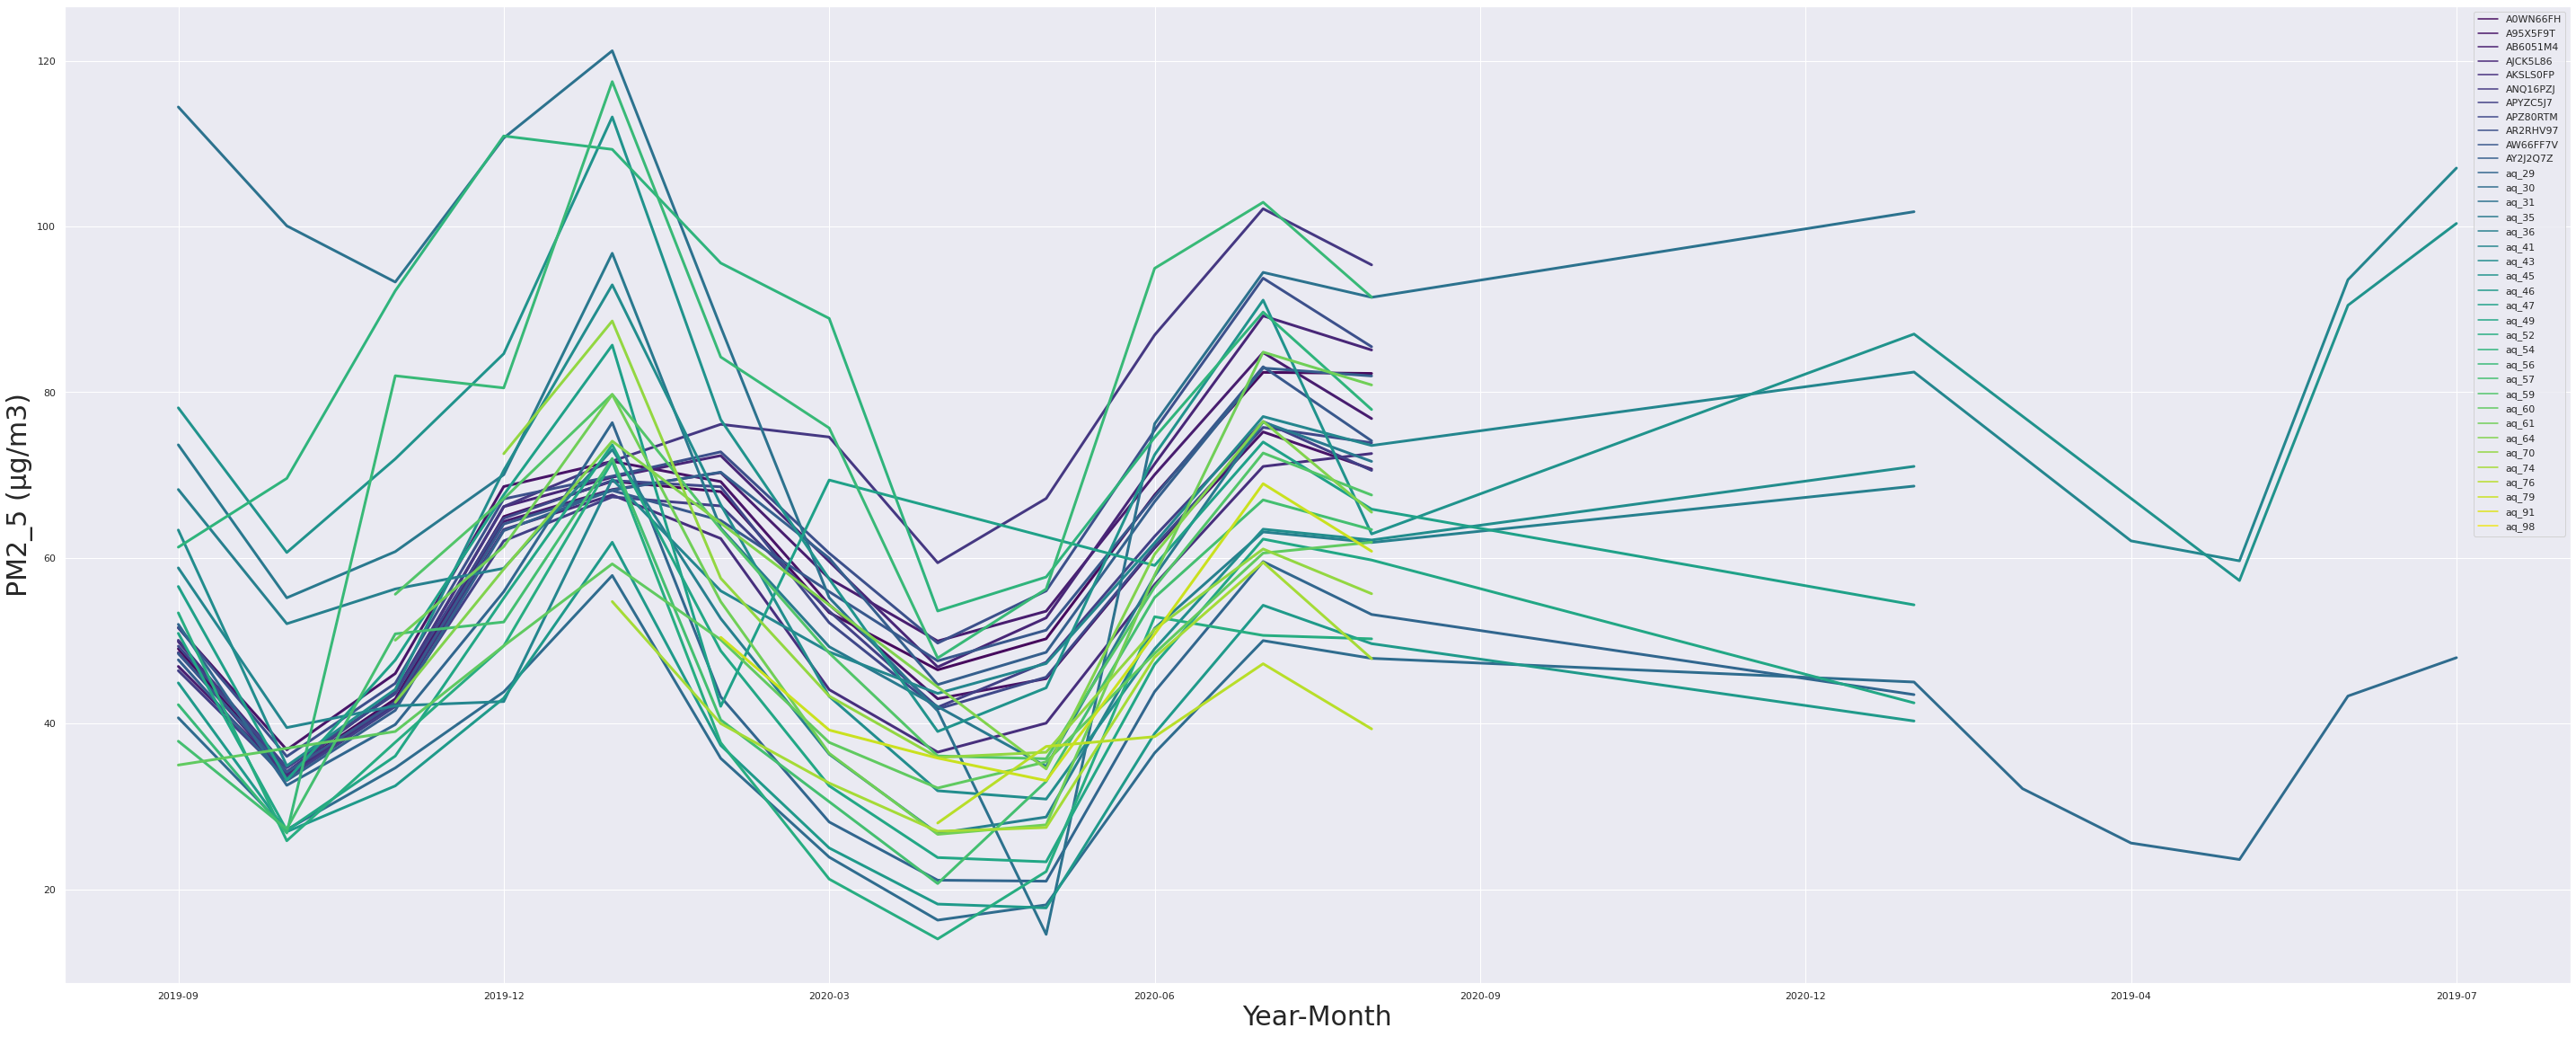

In [27]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(50,20)})

ax = sns.lineplot(data=df_monthly, x ='YM', y = 'pm2_5',
                  hue='device', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('PM2_5 (µg/m3)', fontsize=30)
plt.xlabel('Year-Month', fontsize=30)
plt.show()

#  Time Features

In [28]:
train_set['year'] = pd.DatetimeIndex(train_set['date']).year
train_set['month'] = pd.DatetimeIndex(train_set['date']).month
train_set['day'] = pd.DatetimeIndex(train_set['date']).day
train_set['quarter'] = pd.DatetimeIndex(train_set['date']).quarter
train_set["weekday"] = pd.DatetimeIndex(train_set["date"]).weekday
train_set['day_of_year'] = pd.DatetimeIndex(train_set['date']).dayofyear
train_set['week_of_year'] = pd.DatetimeIndex(train_set['date']).weekofyear
train_set['month_wkday'] = train_set["month"].astype(str) + "_" +  train_set["day"].astype(str)
train_set['season'] = train_set.month%12 // 3 + 1

Temmp and Humidity

In [29]:
# train_set['avgtemp_humid']= (train_set["temp_mean"] + train_set['humidity'])/2

# Encoding cyclical features

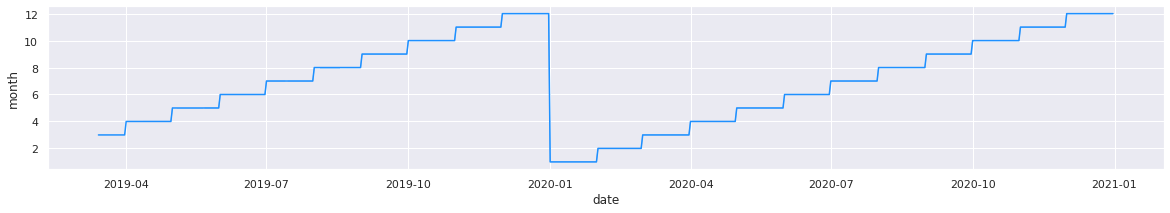

In [30]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
sns.lineplot(x=train_set.date, y=train_set.month, color='dodgerblue')
plt.show()

In [31]:
month_in_year = 12
train_set['month_sin'] = np.sin(2*np.pi*train_set.month/month_in_year)
train_set['month_cos'] = np.cos(2*np.pi*train_set.month/month_in_year)

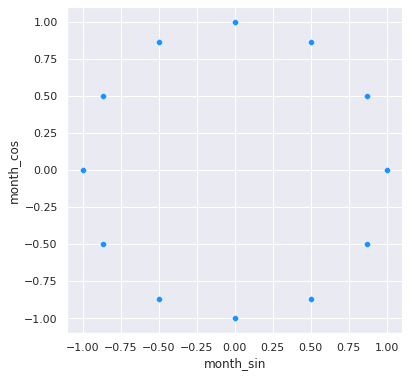

In [32]:
days_in_month = 30
train_set['day_sin'] = np.sin(2*np.pi*train_set.day/days_in_month)
train_set['day_cos'] = np.cos(2*np.pi*train_set.day/days_in_month)

days_in_year = 365
train_set['day_of_year_sin'] = np.sin(2*np.pi*train_set.day_of_year/days_in_year)
train_set['day_of_year_cos'] = np.cos(2*np.pi*train_set.day_of_year/days_in_year)

weeks_in_year = 52.1429
train_set['week_of_year_sin'] = np.sin(2*np.pi*train_set.week_of_year/weeks_in_year)
train_set['week_of_year_cos'] = np.cos(2*np.pi*train_set.week_of_year/weeks_in_year)

quarters_in_year = 4
train_set['quarter_sin'] = np.sin(2*np.pi*train_set.quarter/quarters_in_year)
train_set['quarter_cos'] = np.cos(2*np.pi*train_set.quarter/quarters_in_year)

seasons_in_year = 4
train_set['season_sin'] = np.sin(2*np.pi*train_set.season/seasons_in_year)
train_set['season_cos'] = np.cos(2*np.pi*train_set.season/seasons_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=train_set.month_sin, y=train_set.month_cos, color='dodgerblue')
plt.show()

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
unwanted=["date","ID","device","YM","year","month", "site_latitude", "site_longitude","pm2_5",'day', 'weekday', 'day_of_year', 'week_of_year', 'month_wkday', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter', 'quarter_sin', 'quarter_cos', 'season_sin', 'season_cos']
decompose_cols = [col for col in train_set.columns if col not in unwanted]

In [34]:
percent_missing = train_set.isnull().sum() > 0
missing_values_train = pd.DataFrame({'column_name': train_set.columns,
                                 'percent_missing': percent_missing})
missing_values_train.iloc[:35]


,column_name,percent_missing
ID,ID,False
date,date,False
device,device,False
site_latitude,site_latitude,False
site_longitude,site_longitude,False
humidity,humidity,False
temp_mean,temp_mean,False
SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density,True
SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_column_number_density_amf,True
SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_SO2_slant_column_number_density,True


In [35]:
train_set = train_set.fillna(0)


In [36]:
train_set

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,season_sin,season_cos
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,...,-0.587785,-0.809017,0.974100,0.226116,0.992222,0.124480,1.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.390741,32.582257,0.874493,21.545833,0.000172,0.892539,0.000153,...,0.406737,-0.913545,-0.977848,0.209315,-0.974101,0.226112,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.285751,32.578325,0.729340,23.568655,-0.000223,0.703101,-0.000149,...,-0.951057,-0.309017,-0.171293,0.985220,-0.137284,0.990532,-2.449294e-16,1.000000e+00,1.000000e+00,6.123234e-17
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,...,-0.866025,-0.500000,0.769415,0.638749,0.821476,0.570243,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
4,ID_4XOX2V6SK0,2019-04-17,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,...,-0.406737,-0.913545,0.963471,-0.267814,0.936882,-0.349646,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14172,ID_NYKGOYFBKZ,2020-08-25,aq_76,0.357987,32.584100,0.786575,23.790833,0.000000,0.000000,0.000000,...,-0.866025,0.500000,-0.816538,-0.577292,-0.880011,-0.474954,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
14173,ID_IWO4EVLHSQ,2020-08-21,AB6051M4,0.390741,32.582257,0.828441,21.801389,0.000000,0.000000,0.000000,...,-0.951057,-0.309017,-0.774884,-0.632103,-0.816536,-0.577294,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
14174,ID_G1M1IMY9WU,2020-11-07,AB6051M4,0.390741,32.582257,0.859490,21.851042,0.000000,0.000000,0.000000,...,0.994522,0.104528,-0.790946,0.611886,-0.758309,0.651896,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00
14175,ID_DXV65Q1QXI,2020-09-10,aq_61,0.373078,32.628226,0.833803,21.948864,0.000000,0.000000,0.000000,...,0.866025,-0.500000,-0.942761,-0.333469,-0.967937,-0.251194,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000e+00


In [37]:
null_cols = train_set.columns[train_set.isna().any()].tolist()
print(null_cols)

[]


In [38]:
for col in decompose_cols:
    decomp = seasonal_decompose(train_set[col], period=52, model='additive', extrapolate_trend='freq')
    train_set[f"{col}_trend"] = decomp.trend
    train_set[f"{col}_seasonal"] = decomp.seasonal

In [39]:
train_set["humidity_trend"]

0        0.787657
1        0.787854
2        0.788051
3        0.788248
4        0.788444
           ...   
14172    0.762857
14173    0.762638
14174    0.762419
14175    0.762200
14176    0.761981
Name: humidity_trend, Length: 14177, dtype: float64

In [40]:
train_set.corr()["pm2_5"].sort_values()[train_set.corr()["pm2_5"].sort_values()< 0]

Ozone_O3_column_number_density_trend                       -0.710910
Cloud_cloud_fraction_trend                                 -0.676088
Ozone_cloud_fraction_trend                                 -0.666944
Formaldehyde_cloud_fraction_trend                          -0.583603
CarbonMonoxide_cloud_height_trend                          -0.520551
                                                              ...   
CarbonMonoxide_sensor_azimuth_angle_seasonal               -0.001007
NitrogenDioxide_NO2_slant_column_number_density_seasonal   -0.000690
UvAerosolIndex_sensor_azimuth_angle                        -0.000682
UvAerosolIndex_sensor_zenith_angle                         -0.000232
NitrogenDioxide_absorbing_aerosol_index_seasonal           -0.000225
Name: pm2_5, Length: 123, dtype: float64

In [41]:
train_set.corr()["pm2_5"].sort_values()[train_set.corr()["pm2_5"].sort_values()> 0]

SulphurDioxide_sensor_azimuth_angle_seasonal              0.000304
SulphurDioxide_solar_zenith_angle_seasonal                0.000405
SulphurDioxide_SO2_column_number_density_15km_seasonal    0.000407
SulphurDioxide_SO2_column_number_density_15km             0.000523
Ozone_O3_column_number_density_seasonal                   0.000918
                                                            ...   
CarbonMonoxide_solar_azimuth_angle_trend                  0.634559
Cloud_solar_azimuth_angle_trend                           0.679019
Ozone_solar_azimuth_angle_trend                           0.683210
UvAerosolIndex_solar_azimuth_angle_trend                  0.686416
pm2_5                                                     1.000000
Name: pm2_5, Length: 95, dtype: float64

In [42]:
weeks_in_month = 4
seasonal_cols = [col for col in train_set.columns if "seasonal" in col]

In [43]:
print(seasonal_cols)

['humidity_seasonal', 'temp_mean_seasonal', 'SulphurDioxide_SO2_column_number_density_seasonal', 'SulphurDioxide_SO2_column_number_density_amf_seasonal', 'SulphurDioxide_SO2_slant_column_number_density_seasonal', 'SulphurDioxide_cloud_fraction_seasonal', 'SulphurDioxide_sensor_azimuth_angle_seasonal', 'SulphurDioxide_sensor_zenith_angle_seasonal', 'SulphurDioxide_solar_azimuth_angle_seasonal', 'SulphurDioxide_solar_zenith_angle_seasonal', 'SulphurDioxide_SO2_column_number_density_15km_seasonal', 'CarbonMonoxide_CO_column_number_density_seasonal', 'CarbonMonoxide_H2O_column_number_density_seasonal', 'CarbonMonoxide_cloud_height_seasonal', 'CarbonMonoxide_sensor_altitude_seasonal', 'CarbonMonoxide_sensor_azimuth_angle_seasonal', 'CarbonMonoxide_sensor_zenith_angle_seasonal', 'CarbonMonoxide_solar_azimuth_angle_seasonal', 'CarbonMonoxide_solar_zenith_angle_seasonal', 'NitrogenDioxide_NO2_column_number_density_seasonal', 'NitrogenDioxide_tropospheric_NO2_column_number_density_seasonal', 'N

In [44]:
timeshift=4
for col in seasonal_cols:
    train_set[f"{col}_shift_r_2M"] = train_set[col].shift(-2*timeshift)
    train_set[f"{col}_shift_r_1M"] = train_set[col].shift(-1*timeshift)
    train_set[f"{col}_shift_1M"] = train_set[col].shift(1*timeshift)
    train_set[f"{col}_shift_2M"] = train_set[col].shift(2*timeshift)
    train_set[f"{col}_shift_3M"] = train_set[col].shift(3*timeshift)

# label Encoding

In [45]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
encoded_cols = [col for col in train_set.select_dtypes('object').columns if col not in ["ID"]]
encoded_cols = encoded_cols
print(encoded_cols)

['device', 'YM', 'month_wkday']


In [46]:
for col in encoded_cols:
    train_set[col] = label_encoder.fit_transform(train_set[col])

In [47]:
train_df = train_set[:ntrain]
test_df = train_set[ntrain:]

In [48]:
# # Eda
# f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 15))
# f.suptitle('Seasonal Components of Features', fontsize=16)
# sns.lineplot(x=train_df.date, y=train_df.humidity_seasonal, ax=ax[0], color='dodgerblue', label='P25')
# ax[0].set_ylabel(ylabel='humidity', fontsize=14)

# sns.lineplot(x=train_df.date, y=train_df.temp_mean_seasonal, ax=ax[1], color='dodgerblue', label='Bastia Umbra')
# ax[1].set_ylabel(ylabel='Temp_mean', fontsize=14)

# sns.lineplot(x=train_df.date, y=train_df.CarbonMonoxide_CO_column_number_density_seasonal, ax=ax[2], color='dodgerblue')
# ax[2].set_ylabel(ylabel='CarbonMonoxide_CO_column_number_density', fontsize=14)

# sns.lineplot(x=train_df.date, y=train_df.UvAerosolIndex_solar_azimuth_angle_seasonal, ax=ax[3], color='dodgerblue')
# ax[3].set_ylabel(ylabel='UvAerosolIndex_solar_azimuth_angle', fontsize=14)

# sns.lineplot(x=train_df.date, y=train_df.Ozone_cloud_fraction_seasonal, ax=ax[4], color='dodgerblue')
# ax[4].set_ylabel(ylabel='Ozone_cloud_fraction', fontsize=14)

# plt.tight_layout()
# plt.show()
 


In [49]:
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# plot_acf(train_df.humidity_seasonal,lags=100, ax=ax[0])
# plot_pacf(train_df.humidity_seasonal,lags=100, ax=ax[1])
# plt.show()

In [50]:
# df1 = train_df.copy(deep = True)
# df1.set_index('date',inplace = True)
# df1 = df1.resample('W').sum()
# df1.head()

In [51]:
# from statsmodels.tsa.stattools import adfuller

# def check_stationarity(series):
#     result = adfuller(series.values)

#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))

#     if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
#         print("\u001b[32mStationary\u001b[0m")
#     else:
#         print("\x1b[31mNon-stationary\x1b[0m")

In [52]:
# check_stationarity(df1["pm2_5"])

In [53]:
# #Target Variable isualization.
# color1 = ['#296C92','#3EB489']
# fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (15,5))

# plt.subplot(1,2,1)
# sns.distplot(train_df['pm2_5'])
# plt.title('Distribution, target value: pm2_5')

# plt.subplot(1,2,2)
# sns.distplot(df1['pm2_5']);
# plt.title('Distribution of resampled dataset, target value:pm2_5')

# fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
# plt.subplot(1,1,1)
# sns.lineplot(x = train_df["date"] ,y = 'pm2_5',data = train_df,palette = color1)
# plt.title('pm2_5 vs Date')

# plt.show()
# fig.tight_layout(pad = 2)


In [54]:
# print(np.mean(train_df["pm2_5"]))
# print(np.median(train_df["pm2_5"]))

In [55]:
# df1['Log_pm2_5'] = np.log(df1['pm2_5'])
# df1_log_diff = df1['Log_pm2_5'].diff()
# df1_log_diff = df1_log_diff.dropna()
# dec = seasonal_decompose(df1_log_diff,period = 36).plot()
# plt.show()

In [56]:
# check_stationarity(df1_log_diff)

In [57]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df1_log_diff)
# plt.show()

In [58]:
# def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
#     if not isinstance(y, pd.Series):
#         y = pd.Series(y)
        
#     with plt.style.context(style):    
#         fig = plt.figure(figsize=figsize)
#         layout = (2, 2)
#         ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
#         acf_ax = plt.subplot2grid(layout, (1, 0))
#         pacf_ax = plt.subplot2grid(layout, (1, 1))
        
#         y.plot(ax=ts_ax)
#         p_value = sm.tsa.stattools.adfuller(y)[1]
#         ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
#         smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
#         smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
#         plt.tight_layout()
# tsplot(df1['pm2_5'],lags = 10)

In [59]:
X = train_df.drop(columns=["pm2_5", "ID"])
y = train_df["pm2_5"]

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import catboost as catt
fold_pred=[]

oof_pred = []

params =     params = {
        'iterations':10000,
        'random_state':42,
        'bootstrap_type':'Bernoulli',
        'max_depth': 7,
        'learning_rate': 0.008436034013684798,
        'l2_leaf_reg': 0.8908564261285311,
         }
cross_val = KFold()
fold= KFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in cross_val.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = catt.CatBoostRegressor(bootstrap_type='Bernoulli', task_type="GPU")

    model.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_absolute_error(y_test,preds)))  
    oof_pred.append(mean_absolute_error(y_test,preds))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(p2)
    

print(np.mean(oof_pred))

In [ ]:
# def objective(trial):
#     fold_pred=[]
#     oof_pred = []


#     param = {
#         'loss_function': 'RMSE',
#         'task_type': 'GPU',
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
#         'n_estimators':  25000,
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
#         'random_state': trial.suggest_categorical('random_state', [2020]),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#         'bootstrap_type':'Bernoulli', 
#     }
    


#     fold= KFold(n_splits=10)#15#5#10
#     i=1
#     for train_index, test_index in fold.split(X,y):
        
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         model = catt.CatBoostRegressor(**param)

#         model.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100
#         preds= model.predict(X_test)
#         print("err: ",(mean_absolute_error(y_test,preds)))
#         oof_pred.append(mean_absolute_error(y_test,preds))
#         p2 = model.predict(test_df[X.columns])
#         fold_pred.append(p2)
#     return np.mean(oof_pred)

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import catboost as catt
# import optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [ ]:
submission_df = test_df[["ID"]].copy()
submission_df["pm2_5"]=np.mean(fold_pred, axis=0)
submission_df.head(5)

In [ ]:
submission_df.to_csv("submission17.csv", index=False)

In [ ]:
pd.options.display.max_rows = 2200

def get_catt_varimp(model, train_columns, max_vars=350):
    
    feature_importances_percentage = (model.feature_importances_/sum(model.feature_importances_))*100
    cv_varimp_df = pd.DataFrame((train_columns, feature_importances_percentage)).T
    cv_varimp_df.columns = ['feature_name', 'varimp (%)']
    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]
    return cv_varimp_df
get_catt_varimp(model, X.columns)